In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [3]:
# Raw Data
df = pd.read_csv('../data/raw/rating.csv')
df.head(5)

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [4]:
# Train Data (subset of all interactions)
df = pd.read_csv('../data/interactions_train_df.csv')
df = df[['user_id', 'content_id', 'game', 'view']]
df.head(5)

,user_id,content_id,game,view
0,134,1680,Far Cry 3 Blood Dragon,1
1,2219,1938,Gone Home,1
2,3315,3711,Serious Sam 3 BFE,1
3,3440,4784,Velvet Sundown,1
4,870,4104,Super Hexagon,1


In [5]:
# Content Data of Games
df_game = pd.read_csv('../data/articles_df.csv')
df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


### Create a Matrix of Interactions

In [6]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df.head(10)

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
users_items_matrix_df.shape

(3757, 4862)

In [8]:
users_items_matrix_df.values.mean()*100

0.5042609616033342

## Model

In [23]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def stackedAutoEncoder(X):
    '''
    Stacked Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc1 = Dense(512, activation='selu', name='EncLayer1')(input_layer)
    enc2 = Dense(256, activation='selu', name='EncLayer2')(enc1)

    # Latent Space
    # -----------------------------
    lat_space = Dense(128, activation='selu', name='LatentSpace')(enc2)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec2 = Dense(256, activation='selu', name='DecLayer2')(lat_space)
    dec1 = Dense(512, activation='selu', name='DecLayer1')(dec2)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec1)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [10]:
users_items_matrix_df.values[0].reshape(1, -1).shape

(1, 4862)

In [45]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [27]:
# Build model
model = stackedAutoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserScore (InputLayer)      [(None, 4862)]            0         
                                                                 
 EncLayer1 (Dense)           (None, 512)               2489856   
                                                                 
 EncLayer2 (Dense)           (None, 256)               131328    
                                                                 
 LatentSpace (Dense)         (None, 128)               32896     
                                                                 
 Dropout (Dropout)           (None, 128)               0         
                                                                 
 DecLayer2 (Dense)           (None, 256)               33024     
                                                                 
 DecLayer1 (Dense)           (None, 512)               1315

### Train Model

In [28]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/50
53/53 [==============================] - 3s 43ms/step - loss: 0.0345 - val_loss: 0.0046
Epoch 2/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0165 - val_loss: 0.0031
Epoch 3/50
53/53 [==============================] - 2s 41ms/step - loss: 0.0111 - val_loss: 0.0026
Epoch 4/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 5/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 6/50
53/53 [==============================] - 2s 45ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 7/50
53/53 [==============================] - 2s 42ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 8/50
53/53 [==============================] - 2s 41ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 9/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 10/50
53/53 [==============================] - 2s 41ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 11/

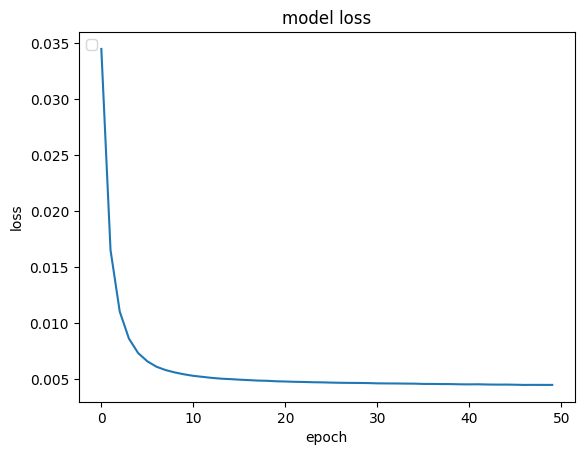

In [29]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [30]:
# Predict new Matrix Interactions, set score zero on visualized games
new_matrix = model.predict(X) * (X == 0)

118/118 [==============================] - 1s 8ms/step


In [31]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,-0.005670,-0.005159,0.010644,0.004254,0.003479,0.008139,0.007362,-0.000763,0.007538,0.000774,...,-0.004848,0.005493,0.004067,0.004285,-0.006561,-0.017824,0.003586,0.011903,-0.029927,0.007527
1,-0.018484,0.000328,-0.003276,-0.013705,-0.009973,-0.003457,-0.024034,0.005437,-0.000252,0.001734,...,-0.008002,-0.005734,0.002828,0.015371,-0.001708,-0.018003,-0.010190,-0.003776,0.001335,0.010309
2,0.001386,0.004019,0.021185,0.009723,0.007868,0.012844,0.003503,0.005699,-0.003797,0.024556,...,-0.000990,-0.006401,0.001550,0.037729,-0.006723,-0.000808,-0.002816,0.006665,-0.036625,-0.002776
3,-0.006033,0.002623,0.001622,-0.005629,-0.001141,-0.002334,0.001240,-0.002919,0.006455,0.007091,...,-0.004510,-0.005173,-0.002233,0.004624,0.000464,-0.010155,0.003569,-0.002181,-0.023645,0.007978
4,-0.006288,0.007978,0.002471,-0.005252,-0.005905,0.002388,0.001401,-0.000745,0.010903,0.004629,...,-0.004204,-0.006248,-0.003518,0.011336,-0.001501,-0.007857,0.003210,-0.002476,-0.013384,0.010002


In [32]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-0.29837897 1.5506902


In [33]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [34]:
# Games previously purchased by the user
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2057,1.0,Half-Life 2 Episode One
2059,1.0,Half-Life 2 Lost Coast


In [35]:
# Recommended User Games
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
2056,0.259467,Half-Life 2 Deathmatch
2058,0.204783,Half-Life 2 Episode Two
978,0.191038,Counter-Strike Source
2457,0.139446,Left 4 Dead 2
2062,0.139369,Half-Life Deathmatch Source
1126,0.103746,Day of Defeat Source
2064,0.095582,Half-Life Source
3197,0.094979,Portal 2
2054,0.085065,Half-Life


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [36]:
# Games previously purchased by the user
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
173,1.0,Age of Empires II HD Edition
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4626,1.0,Total War ATTILA
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
4631,1.0,Total War SHOGUN 2
4328,1.0,The Elder Scrolls V Skyrim


In [37]:
# Recommended User Games
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
4330,0.259697,The Elder Scrolls V Skyrim - Dragonborn
3837,0.134178,Skyrim High Resolution Texture Pack
1328,0.095534,Dota 2
3792,0.089398,Sid Meier's Civilization V
1667,0.086719,Fallout New Vegas
1670,0.076890,Fallout New Vegas Honest Hearts
1668,0.073907,Fallout New Vegas Courier's Stash
4630,0.071186,Total War ROME II - Emperor Edition
1669,0.066693,Fallout New Vegas Dead Money


In [40]:
import tensorflow as tf

# Save the model 
model.save("model_stacked.h5")

In [41]:
X = np.zeros((1, 6))
print(X)
X[0, [1,3,4]] = 1
print(X)

[[0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 0.]]


In [48]:
new_users_items_matrix_df.loc[0].values

array([-0.0056697 , -0.0051593 ,  0.01064383, ...,  0.01190315,
       -0.02992746,  0.00752738], dtype=float32)

In [52]:
X[0].reshape(1,-1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [54]:
X.shape

(3757, 4862)

In [68]:
5112 - 4862
2055 - 1941

114

In [94]:
user_sample = pd.read_csv("../data/user-content_sample.csv")
# user_sample.loc[0][user_sample.columns] = 0

In [95]:
user_sample[user_sample.columns] = 0
user_sample

,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
user_sample.values.shape

(1, 4862)

In [98]:
user_sample[["3196","4221","2055","2057","2059"]] = 1
# z = np.zeros((1, users_items_matrix_df.shape[1]))
# z[0,[3196,4221,2055,2057,2059  ]] = 1
z = user_sample.values

In [ ]:
user_sample = pd.read_csv("../data/user-content_sample.csv")
user_sample[user_sample.columns] = 0
user_sample[["3196","4221","2055","2057","2059"]] = 1
X = user_sample.values


In [99]:
np.where(X[1011] == 1)


(array([1941, 1943, 1945, 3021, 4006], dtype=int64),)

In [100]:
np.where(z == 1)

(array([0, 0, 0, 0, 0], dtype=int64),
 array([1941, 1943, 1945, 3021, 4006], dtype=int64))

In [56]:
def recommender_for_user_(interact_matrix, df_content, topn=10):
    '''
    Recommender Games for Users
    '''
    pred_scores = interact_matrix.loc[0].values

    df_scores = pd.DataFrame({'content_id': list(users_items_matrix_df.columns),
                              'score': pred_scores})

    df_rec = df_scores.set_index('content_id')\
        .join(df_content.set_index('content_id'))\
        .sort_values('score', ascending=False)\
        .head(topn)[['score', 'game']]

    return df_rec[df_rec.score > 0]


In [101]:
new_matrix = model.predict(z) * (z == 0)

new_users_items_matrix_df = pd.DataFrame(new_matrix,
                                            columns=users_items_matrix_df.columns)

# Recommended User Games
predictions = recommender_for_user_(
    interact_matrix=new_users_items_matrix_df,
    df_content=df_game)

predictions

1/1 [==============================] - 0s 66ms/step


,score,game
content_id,,
2056,0.259467,Half-Life 2 Deathmatch
2058,0.204783,Half-Life 2 Episode Two
978,0.191037,Counter-Strike Source
2457,0.139446,Left 4 Dead 2
2062,0.139369,Half-Life Deathmatch Source
1126,0.103746,Day of Defeat Source
2064,0.095582,Half-Life Source
3197,0.094979,Portal 2
2054,0.085065,Half-Life
